# Trabalho 1 de ALEST-II 

Criar um programa 

- **Nomes:**
    - *João Henrique da Luz*
    - *Ighor Talles*

### *Bibliotecas*
- pandas: Gerar df para visualização dos dados em tabelas
- matplotlib e seaborne: Gerar gráficos para visualização de dados e comparação
- time: Para registro de tempo das tarefas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

## Criar um algoritmo Modificado de Árvore de Busca

- Criar a classe Node
- Criar um algoritmo de Árvore convencional
    - O algoritmo deve caminhar pela árvore utilizando o número de CPU's disponiveis
    - Definir duas políticas de caminhamento na árvore ("MIN")-("MAX")
    - Criar uma função de caminhamento para utilizar as duas políticas 

### **Classe Node**

In [2]:
class Node():
    def __init__(self, valor, tempo):
        self.valor = valor
        self.tempo_restante = tempo
        self.tempo_restante_original = tempo
        self.filhos = []
        self.pai = None
        self.free = False

    def adicionar_filho(self, filho):
        """Adiciona os filhos na lista do Nodo pai"""
        filho.pai = self
        self.filhos.append(filho)
        

### **Class ProcessTree V2**
- Classe de Árvore de Busca adaptado

In [8]:
class ProcessTree():
    def __init__(self):
        self.root = None
        self.nodes = {}

    def get_or_create(self, nome):
        """Verifica se o nome está inserido na lista node,
        se não ele cria um Nodo novo"""  
        if nome not in self.nodes:
            ident, tempo = nome.split("_")
            tempo = int(tempo)
            self.nodes[nome] = Node(ident, tempo)
        return self.nodes[nome]
    
    def add_relation(self, pai_nome, filho_nome):
        """Cria uma relação de dependencia entre o nodo pai e o nodo filho"""
        pai = self.get_or_create(pai_nome)
        filho = self.get_or_create(filho_nome)
        pai.adicionar_filho(filho)

    def find_root(self):
        """Percorre a Arvore até encontrar a root"""
        for node in self.nodes.values():
            if node.pai is None:
                self.root = node
                self.root.free = True
                return self.root
        return None

    def insert(self, valor, tempo):
        """Insere um novo nó na árvore em ordem hierárquica."""
        new = Node(valor, tempo)
        if self.root is None:
            new.free = True
            self.root = new
            return
        fila = [self.root]
        while fila:
            node = fila.pop(0)
            if not node.filhos or valor < node.filhos[-1].valor:
                node.adicionar_filho(new)
                break
            else:
                fila.extend(node.filhos)

    def reset(self):
        """Reinicia tempos e libera a raiz para execução."""
        for node in self.nodes.values():
            node.tempo_restante = node.tempo_restante_original
            node.free = False
        self.find_root()
        self.ready_queue = [self.root]  # inicializa fila de nós prontos

    
    def execution(self, cpu, politica):
        """Executa os processos conforme CPUs e política de escalonamento."""
        total_time = 0
        while self.ready_queue:     # O ready_queue mantém apenas nós livres e ainda não finalizados
                                    # Ordena os prontos conforme política
            if politica == "MAX":
                self.ready_queue.sort(key=lambda x: x.valor)
            else:  
                self.ready_queue.sort(key=lambda x: x.valor, reverse=True)

            ativos = self.ready_queue[:cpu]
            menor_tempo = min(node.tempo_restante for node in ativos)
            total_time += menor_tempo

            novos_prontos = []
            for node in ativos:
                node.tempo_restante -= menor_tempo
                if node.tempo_restante == 0:
                    for filho in node.filhos:
                        filho.free = True
                        novos_prontos.append(filho)

            self.ready_queue = [n for n in self.ready_queue if n.tempo_restante > 0]    # remove os ativos que terminaram da ready_queue
            self.ready_queue.extend(novos_prontos)      # adiciona os novos prontos

        return total_time


# **ProcessTree V2**

## *Abertura e Tratamento do Arquivo*
- Abri o arquivo .txt
- Extrair a quantidade de processadores do Servidor
- Tratar a entrada de dados
    - Tratar a saída de Task retirando as "->"
    - Transformar a saída em tuplas (pai, filho)

## *Criar a Árvore*
- Cria uma arvore 
    - Cria os nodos pais e filhos
    - Descobre a raiz
    - Percorre a Arvore nas duas politicas

## *Criar um Arquivo .txt contendo os logs de cada caso.*
- Abrir/Criar um arquivo .txt e armazenar os logs nele
- O arquivo deve conter:
    - Nome do Caso Estudado
    - N° de Processador
    - Política Utilizada
    - Tempo Simulado
    - Tempo Real de Execução

In [11]:
# Lista de Casos
inicio = time() # --> Contagem de Tempo Inicial
list_arq = ["5", "6", "7", "10", "100", "200", "500", "1000", "2000", "5000", "10000", "20000"]

def separeting(string:str):
    word = string.split('->')
    pai = word[0].strip()
    filho = word[1].strip()
    return pai, filho

for num in list_arq:
    with open(f"Entrada de Arquivos/caso{num}.txt") as arquivo:
        caso = arquivo.readlines()

    cpu = int(str(caso[0])[7:])
    tasks = list(map(lambda x: x[:-1], caso[1:]))
    

    # Criar a ProcessTree e Setar a Politica de Caminhamento
    p_tree = ProcessTree()
    politica = ["MIN", "MAX"]
    result = {}

    for pai, filho in map(separeting, tasks):
        p_tree.add_relation(pai, filho)

    # Procura a Root
    p_tree.find_root()

    # Faz o Caminhamento de Acordo com a Política e retorna o tempo
    for pol in politica:
        inicio = time()
        p_tree.reset()
        total_time = p_tree.execution(cpu=cpu, politica=pol)
        fim = time()
        result[pol] = total_time
        result[f"Tempo_{pol}"] = fim-inicio

    if (result["MAX"]) > (result["MIN"]): 
        maior = "Min"
    elif (result["MIN"]) > (result["MAX"]): 
        maior = "Max"
    else:
        maior = "Na/"

    # Cria um Arquivo .txt contendo os logs de cada operação
    with open("Saida de Arquivos/log.txt", "a") as log:
        linha = (f"Arquivo:{f'caso{num}.txt'} | CPU:{cpu} | MIN:{result["MIN"]} | MAX:{result["MAX"]} | Otimizado:{maior} | Temp_MIN:{result["Tempo_MIN"]} | Temp_MAX:{result["Tempo_MAX"]}\n")
        log.write(linha)

fim = time() # --> Contagem de Tempo Final

# --Visualização-- #
print("Fim")
print(f"O tempo total foi: {fim - inicio}")

Fim
O tempo total foi: 1.06242036819458


## **Gerar Relatórios sobre o Desempenho da ProcessTree**
    - Fazer um Relatório de tempo em Relação às Políticas "MIN" e "MAX"
        - Criar um data frame a partir do "log.txt"
        - Criar uma coluna "Delta" (Diferença de MIN e MAX)
        - Gerar um Arquivo Tabelas_log.xlsx

In [18]:
# Abri o arquivo "log.txt" e transforma ele em um DataFrame
log_df = pd.read_csv("Saida de Arquivos/log.txt", sep='|', header=None, names=['Arquivo', 'CPU', 'MIN', 'MAX', 'Otimizado', 'Temp_MIN', 'Temp_MAX'])

# Trata as entradas do .txt para ter uma planilha limpa
log_df["Arquivo"] = log_df["Arquivo"].str.split(":").str[1].astype(str)
log_df["Arquivo"] = log_df["Arquivo"].str.replace('.txt', '', regex=False)
log_df["MIN"] = log_df["MIN"].str.split(":").str[1].astype(int)
log_df["MAX"] = log_df["MAX"].str.split(":").str[1].astype(int)
log_df["CPU"] = log_df["CPU"].str.split(":").str[1].astype(int)
log_df["Otimizado"] = log_df["Otimizado"].str.split(":").str[1].astype(str)
log_df["Delta max|min"] = (log_df["MAX"] - log_df["MIN"]).abs() # Cria a Coluna Delta com a diferença entra MAX e MIN
log_df["Temp_MIN"] = log_df["Temp_MIN"].str.split(":").str[1].astype(float).abs().round(2)
log_df["Temp_MAX"] = log_df["Temp_MAX"].str.split(":").str[1].astype(float).abs().round(2)


# Cria um arquivo .xlsx a partir do DataFrame
with pd.ExcelWriter("Saida de Arquivos/Tabelas_log.xlsx") as writer:
    log_df.to_excel(writer, sheet_name="Resultados", index=False)

# --Visualização-- #
print(f"-="*16, "Data Frame", "=-"*16)
log_df

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Data Frame =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


,Arquivo,CPU,MIN,MAX,Otimizado,Temp_MIN,Temp_MAX,Delta max|min
0,caso5,4,783,783,Na/,0.00,0.00,0
1,caso6,4,1157,1157,Na/,0.00,0.00,0
2,caso7,4,767,767,Na/,0.00,0.00,0
3,caso10,5,1568,1568,Na/,0.00,0.00,0
4,caso100,12,3315,3315,Na/,0.00,0.00,0
5,caso200,16,4691,4657,Max,0.00,0.00,34
6,caso500,24,7742,6931,Max,0.01,0.01,811
7,caso1000,33,9332,9022,Max,0.02,0.02,310
8,caso2000,46,15560,13493,Max,0.03,0.04,2067
9,caso5000,72,20453,19505,Max,0.12,0.16,948


## DataFrame Para Amostragem de Eficiencia entre Algoritimos

In [17]:
# Abri o arquivo "log.txt" e transforma ele em um DataFrame
log_df = pd.read_csv("Saida de Arquivos/log_tempos_algoritimo.txt", sep='|', header=None, names=['Arquivo', 'CPU', 'Temp_MIN', 'Temp_MAX', 'Temp_MIN(V2)', 'Temp_MAX(V2)'])

# Trata as entradas do .txt para ter uma planilha limpa
log_df["Arquivo"] = log_df["Arquivo"].str.split(":").str[1].astype(str)
log_df["Arquivo"] = log_df["Arquivo"].str.replace('.txt', '', regex=False)
log_df["CPU"] = log_df["CPU"].str.split(":").str[1].astype(int)
log_df["Temp_MIN(V2)"] = log_df["Temp_MIN(V2)"].str.split(":").str[1].astype(float).abs().round(2)
log_df["Temp_MAX(V2)"] = log_df["Temp_MAX(V2)"].str.split(":").str[1].astype(float).abs().round(2)
log_df["Temp_MIN"] = log_df["Temp_MIN"].str.split(":").str[1].astype(float).abs().round(2)
log_df["Temp_MAX"] = log_df["Temp_MAX"].str.split(":").str[1].astype(float).abs().round(2)


# Cria um arquivo .xlsx a partir do DataFrame
with pd.ExcelWriter("Saida de Arquivos/Tabelas_log_tempo.xlsx") as writer:
    log_df.to_excel(writer, sheet_name="Resultados", index=False)

# --Visualização-- #
print(f"-="*16, "Data Frame", "=-"*16)
log_df

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Data Frame =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


,Arquivo,CPU,Temp_MIN,Temp_MAX,Temp_MIN(V2),Temp_MAX(V2)
0,caso5,4,0.00,0.00,0.00,0.00
1,caso6,4,0.00,0.00,0.00,0.00
2,caso7,4,0.00,0.00,0.00,0.00
3,caso10,5,0.00,0.00,0.00,0.00
4,caso100,12,0.00,0.01,0.00,0.00
5,caso200,16,0.02,0.01,0.00,0.00
6,caso500,24,0.07,0.05,0.01,0.01
7,caso1000,33,0.14,0.14,0.02,0.02
8,caso2000,46,0.56,0.53,0.03,0.04
9,caso5000,72,4.09,4.02,0.12,0.16


## **Construir Gráficos sobre o Desempenho da ProcessTree**

- Gerar Gráficos para utilização no trabalho de Pesquisa
    - Gráfico individual de cada Caso (Gráfico de Barras)
    - Gráfico de linhas mostrando a diferença entre politicas
    - Gráfico de Todos os Testes (Gráfico de Barras)

### *Gráfico Isolado*
        - Gera um Gráfico Isolado de Colunas para melhor referencia de Otimização entre políticas
        - Adiciona uma linha Tracejada para melhorar a visualização da Diferença 

In [ ]:
for arq in log_df["Arquivo"].unique():
    df_caso = log_df[log_df["Arquivo"] == arq]
    
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_caso.melt(id_vars=["Arquivo"], value_vars=["MIN","MAX"]),
                x="variable", y="value", palette=["#6baed6", "#fc9272"])
    
    # Pega o valor da altura da barra MAX
    max_val = df_caso["MAX"].values[0]
    
    # Adiciona linha tracejada do topo da barra até o eixo Y
    plt.hlines(y=max_val, xmin=-0.2, xmax=1.2, colors="gray", linestyles="--", linewidth=1)
    
    plt.title(f"Tempos do caso: {arq}")
    plt.ylabel("Tempo total")
    plt.xlabel("")
    plt.savefig(f"Saida de Arquivos/Graficos Isolados/caso_isolado_{arq}.png", dpi=300, bbox_inches="tight")
    plt.close()

### *Gráfico Geral de Barras*
     - Gera um Gráfico Geral de Colunas para melhor referencia de Otimização entre políticas

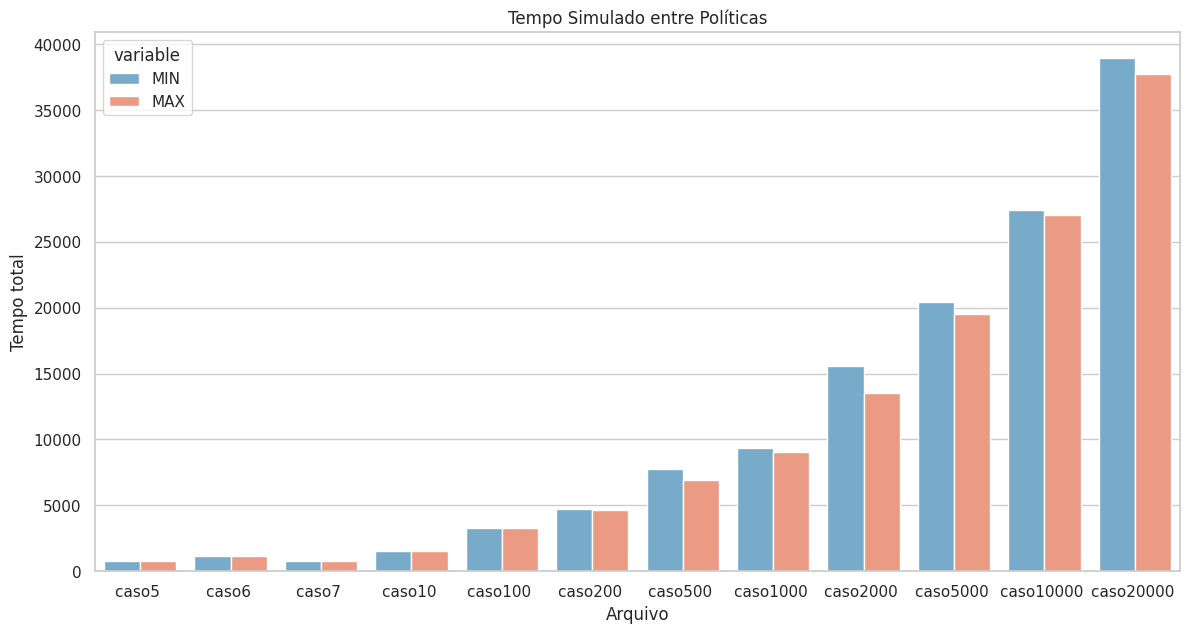

In [7]:
# Gráfico comparativo
sns.set(style="whitegrid")
plt.figure(figsize=(14,7))
sns.barplot(data=log_df.melt(id_vars=["Arquivo"], value_vars=["MIN","MAX"]),
            x="Arquivo", y="value", hue="variable", palette=["#6baed6", "#fc9272"])
plt.ylabel("Tempo total")
plt.title('Tempo Simulado entre Políticas')

# salvar como png
plt.savefig(f"Saida de Arquivos/grafico_barras.png", dpi=300, bbox_inches="tight")

plt.show()

### *Gráfico Geral de Linha*
     - Gera um Gráfico Geral de Linhas para melhor referencia de Otimização entre políticas

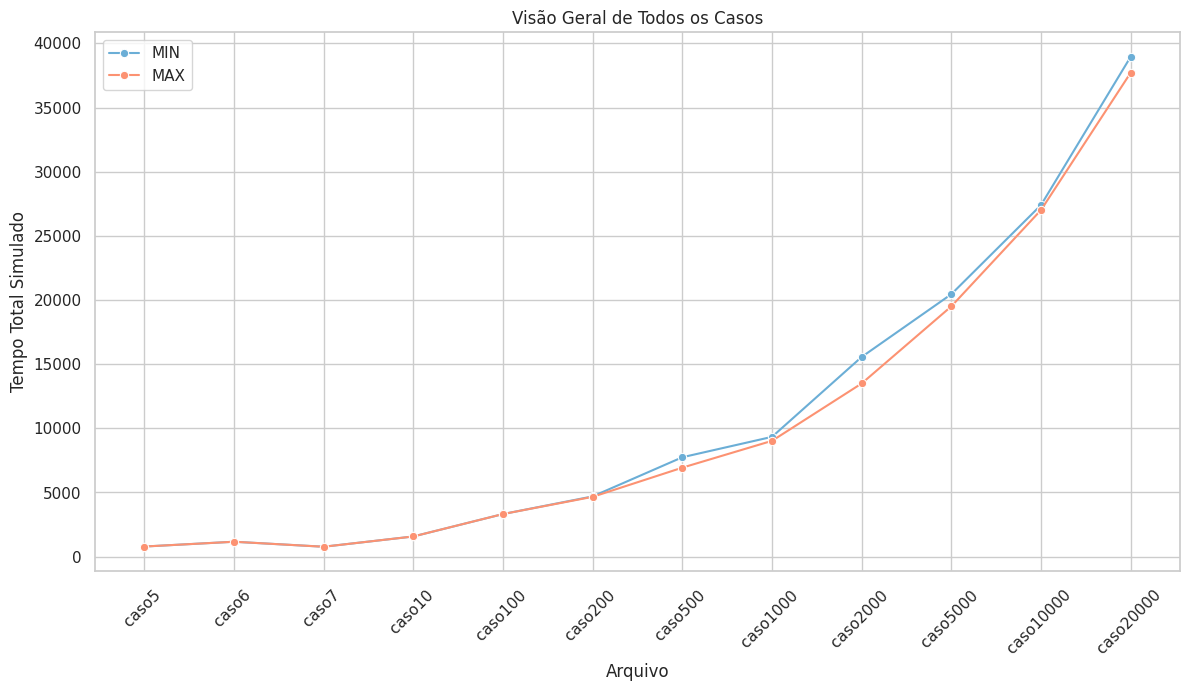

In [8]:
plt.figure(figsize=(14,7))
for var, cor in zip(["MIN","MAX"], ["#6baed6", "#fc9272"]):
    sns.lineplot(data=log_df.melt(id_vars=["Arquivo"], value_vars=[var]), 
                 x="Arquivo", y="value", label=var, color=cor, marker="o")
plt.title("Visão Geral de Todos os Casos")
plt.ylabel("Tempo Total Simulado")
plt.xlabel("Arquivo")
plt.xticks(rotation=45)
plt.legend()
plt.savefig("Saida de Arquivos/grafico_geral_de_linhas.png", dpi=300, bbox_inches="tight")
plt.show()